In [81]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import TypedDict, Literal, Optional
from dotenv import load_dotenv


In [82]:
load_dotenv()


True

In [83]:
model=ChatOpenAI(model='gpt-4o-mini')

In [84]:
class TicketSchema(BaseModel):
    category: Literal["billing","technical","general"]=Field(description="The catagory of ticket mentioned")
    urgency: Literal["high","low"]=Field(description="How urgency or criticality appears to be")

In [85]:
structured_model=model.with_structured_output(TicketSchema)

In [86]:
class TicketState(TypedDict):
    ticket: str
    category: Optional[str]
    urgency: Optional[str]
    priority: Optional[str]
    response: Optional[str]
    


In [87]:
# def route_ticket(state: TicketState) -> Literal[
#     'escalate_ticket',
#     'billing_response',
#     'tech_response',
#     'general_response',
# ]:
#     if state.get('urgency') == 'high':
#         return 'escalate_ticket'
#     if state.get('category') == 'billing':
#         return 'billing_response'
#     if state.get('category') == 'technical':
#         return 'tech_response'
#     return 'general_response'

In [88]:
def classify_ticket(state: TicketState):
    result=structured_model.invoke(state['ticket'])
    return{
        'category':result.category,
        'urgency':result.urgency
    }

def route_ticket_node(state: TicketState):
    return {}

def route_path(state: TicketState)->Literal['escalate_ticket','normal_flow']: # Conditional Node
    if state['urgency']=='high':
        return 'escalate_ticket'
    else:
        return 'normal_flow'
    
def normal_flow_node(state: TicketState):
    return {}

def normal_path(state: TicketState)->Literal['billing_response','tech_response','general_response']:
     # Conditional node 
    if state['category']=="billing":
        return 'billing_response'
    elif state['category']=="technical":
        return 'tech_response'
    else:
        return 'general_response'

def escalate_ticket(state: TicketState):
    prompt=f"""the user reported an urgent issue: \n {state['ticket']} \n\n
    write an apologetic and priority support response."""
    response=model.invoke(prompt).content
    return {'priority':'PRIORITY',
            'response':response}


    
def billing_response(state: TicketState):
    prompt=f"Reply politely to this issue: \n {state['ticket']}"
    response=model.invoke(prompt).content
    return {'priority':'normal','response':response}

def tech_response(state: TicketState):
    prompt=f"Reply politely to this issue: \n {state['ticket']}"
    response=model.invoke(prompt).content
    return {'priority':'normal','response':response}

def general_response(state: TicketState):
    prompt=f"Reply politely to this issue: \n {state['ticket']}"
    response=model.invoke(prompt).content
    return {'priority':'normal','response':response}



In [89]:
graph=StateGraph(TicketState)
graph.add_node('classify_ticket', classify_ticket)
graph.add_node('route_ticket', route_ticket_node)
graph.add_node('normal_flow',normal_flow_node)
graph.add_node('escalate_ticket',escalate_ticket)
#graph.add_node('normal_flow',normal_flow)
graph.add_node('billing_response',billing_response)
graph.add_node('tech_response',tech_response)
graph.add_node('general_response',general_response)


graph.add_edge(START, 'classify_ticket')
graph.add_edge('classify_ticket','route_ticket')
graph.add_conditional_edges('route_ticket', route_path)
graph.add_conditional_edges('normal_flow', normal_path)
graph.add_edge('escalate_ticket', END)
graph.add_edge('billing_response', END)
graph.add_edge('tech_response', END)
graph.add_edge('general_response', END)



workflow=graph.compile()

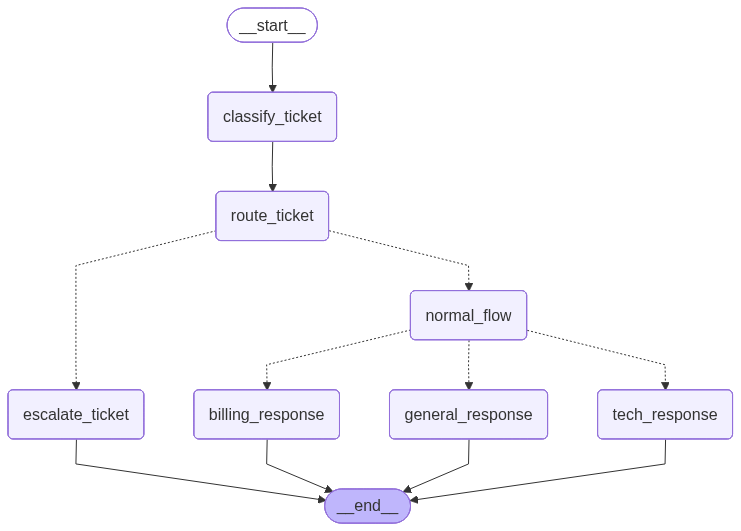

In [90]:
workflow

In [91]:
# Diagnostics: show graph structure and try compile
print("nodes =", list(graph.nodes.keys()))
print("edges =", graph.edges)
print("waiting_edges =", graph.waiting_edges)
print("branches (summary):")
for start, branches in graph.branches.items():
    print("  start:", start)
    for name, spec in branches.items():
        print("    branch name:", name, "  ends:", spec.ends)

try:
    compiled = graph.compile()
    print("compile: OK")
    print("all_edges =", compiled.builder._all_edges)
except Exception:
    import traceback
    traceback.print_exc()

nodes = ['classify_ticket', 'route_ticket', 'normal_flow', 'escalate_ticket', 'billing_response', 'tech_response', 'general_response']
edges = {('tech_response', '__end__'), ('billing_response', '__end__'), ('general_response', '__end__'), ('__start__', 'classify_ticket'), ('escalate_ticket', '__end__'), ('classify_ticket', 'route_ticket')}
waiting_edges = set()
branches (summary):
  start: route_ticket
    branch name: route_path   ends: {'escalate_ticket': 'escalate_ticket', 'normal_flow': 'normal_flow'}
  start: normal_flow
    branch name: normal_path   ends: {'billing_response': 'billing_response', 'tech_response': 'tech_response', 'general_response': 'general_response'}
compile: OK
all_edges = {('general_response', '__end__'), ('tech_response', '__end__'), ('billing_response', '__end__'), ('__start__', 'classify_ticket'), ('escalate_ticket', '__end__'), ('classify_ticket', 'route_ticket')}
